In [3]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
from torch.utils.data import DataLoader
import numpy as np 

from models import MnistNet
from utils import train, test
from utils import load_partition, load_data
from flwr.common.parameter import parameters_to_weights
from collections import OrderedDict

import pickle
from matplotlib import pyplot as plt

In [6]:
DATA_DIR = './datasets/flmnist_iid_2clients'
num_clients = 2
B = 32
# Train loaders for clients
train_sets = [load_partition(cid=x + 1, data_dir=DATA_DIR) for x in range(num_clients)]
_, test_loader = load_data()

/Users/htnu/Research/Flower_FL_examples/utils.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).type(torch.FloatTensor)


## Load saved global model

In [26]:
tensors = np.load("round-1-weights.npz", allow_pickle=True)["arr_0"].tolist()
model = MnistNet()
weights = parameters_to_weights(tensors)
params_dict = zip(model.state_dict().keys(), weights)
state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
model.load_state_dict(state_dict, strict=True)
loss, acc, total = test(model, test_loader, device="mps")

<All keys matched successfully>

## Load the saved history for plotting

In [5]:
file_name = "save_models/FedAvg_R50_C2_B32_E3_2022-07-20-14:13:20/hist.pkl"
f = open(file_name, 'rb')
hist = pickle.load(f)
f.close()

In [11]:
hist_accs = hist.metrics_centralized['centralized_acc']
accs = [x[1] for x in hist_accs]

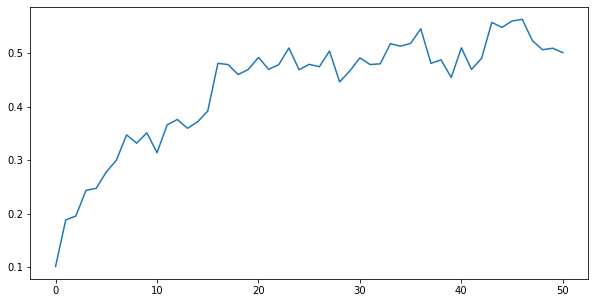

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(accs)), accs)
plt.xlabel('#Round')
plt.ylabel('Accuracy')